In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import multiprocessing as mp
import pickle
from datetime import date
import matplotlib.dates as mdates
import requests
import json
import os
from datetime import date
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp,odeint
import scipy.stats as st

For this compartmental model, we choose to fit the parameters on the data on confirmed cases provided by the Italian Protezione Civile deposited in this repository: https://github.com/pcm-dpc/COVID-19/raw/master/dati-json/

In [20]:
today=date.today()

In [21]:
datafilename='country'+today.strftime("%Y_%m_%d")+'.json'
url='https://github.com/pcm-dpc/COVID-19/raw/master/dati-json/dpc-covid19-ita-andamento-nazionale.json'
response = requests.get(url)
#with open( 'data/PC/'+datafilename, 'w') as f:
#    json.dump(response.json(),f)

In [22]:
with open('data/PC/'+datafilename,'r') as f:
    data_file=json.load(f)
data=pd.DataFrame()
for p in data_file:
    data.loc[p['data'],'Hospitalized']=p['totale_ospedalizzati']
    data.loc[p['data'],'Confirmed_cases']=p['totale_positivi']
    data.loc[p['data'],'Deaths']=p['deceduti']
    data.loc[p['data'],'Recovered']=p['dimessi_guariti']
data.index=pd.to_datetime(data.index)
data['Removed']=data['Deaths']+data['Recovered']

population=60480000.
#population=20000000.
# Start of the study (can be modified as wanted)
#start = today-pd.DateOffset(days=20)
start=pd.to_datetime('2020-02-25 18:00:00')
end = data.index.max()
print('Data updated to: ',str(end))
days=(end-start).days+1
t = np.linspace(start.value, end.value, days)
t = pd.to_datetime(t)
tempo=np.linspace(1,days,days,dtype=int)


Data updated to:  2020-03-30 17:00:00


The model we choose is a Susceptible-Exposed-Infected-Removed (SEIR).  
We specify thaht R0 is not directly a parameter of the model, but you can derive it from other model parameters. Since R0 has the easy-to-say meaning of "secundary cases from a single infected person", it is very popular during this outbreak, and it is very useful to describe the behaviour of the epidemiological curves. In particular, if R0 > 1, the number of infected people increase exponentially without slow-downs. If R0<1, the exponential growth of the outbreak's size does not increase forever and begins to decrease after a single peak. (https://www.icts.res.in/sites/default/files/PuneR0talk.pdf)

In the next chunk, we initialize the parameter we know from literature about COVID-19 (reference will be provided). We also set up some values as a starting point for the fit of the parameters we do not know the value of.

In [23]:
#Parameters
D=3.45
Z=3.68
mu=0.55

# Initial guess
alpha=0.14
R0=2.39
beta=R0/(alpha*D+mu*(1-alpha)*D)
print('Initial parameters:\n days to recover={:1.0f} days to infect={:1.0f}'.format(D,Z))
print('%asynt={:.2f} beta={:.3f} mu={:.2f}'.format(alpha,beta,mu))

Initial parameters:
 days to recover=3 days to infect=4
%asynt=0.14 beta=1.130 mu=0.55


The number of confirmed case is known, but it is almost certain that the number of real infected people is much higher than the number of confirmed cases. At an early stage of the epidemic, howerver, we assume the numbe of initial infected people to be the number of confirmed cases.

Similarly, we assume $E_i$, the initial number of exposed, to be equal to the secondary cases generated from infected individual ($E_i=R_0 * I_i$).

In [24]:
Ir_i=data[data.index==start]['Confirmed_cases'].iloc[0]
Iu_i=Ir_i*(1-alpha)/alpha
E_i=Ir_i*R0+mu*Iu_i*R0
N=population
x0=[N-E_i-Ir_i-Iu_i,E_i,Ir_i,Iu_i]
print('\nInitial conditions:\n S={:.0f},E={:.0f},Ir={:.0f},Iu={:.0f}'.format(x0[0],x0[1],x0[2],x0[3]))


Initial conditions:
 S=60474524,E=3255,Ir=311,Iu=1910


### Fitting parameters

In [14]:
BO=((0.02,0.8,0.02,2.,2.),(1.,1.5,1.,5.,5.)) 
def SEII_ode(t,x,alpha,beta,mu,Z,D):
        S,E,Ir,Iu=x
        N=S+E+Ir+Iu
        dS=-beta*S*Ir/N-mu*beta*S*Iu/N
        dE=beta*S*Ir/N+mu*beta*S*Iu/N-E/Z
        dIr=alpha*E/Z-Ir/D
        dIu=(1-alpha)*E/Z-Iu/D
        return [dS,dE,dIr,dIu]
    
def SEIIinteg(ti,alpha,beta,mu,Z,D):
    #I0,beta,mu=p
    #print(t)
    #x0=[N-E_i-Ir_i-Iu_i,E_i,Ir_i,Iu_i]
    sol=solve_ivp(SEII_ode,[0,days],x0,args=(alpha,beta,mu,Z,D),
                  t_eval=np.arange(0,days+1,1))
    lung=len(sol.y[0])
    #print(sol.y[1].reshape(1,25).shape)
    #print(np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0).shape)
    #print(np.concatenate((sol.y[1].reshape(25,1),sol.y[2].reshape(25,1)),axis=1).shape)
    #print(sol.y[1][ti])
    #print(sol.y[1].shape)
    return sol.y[2]
    #return np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0)
    #return np.concatenate((sol.y[1].reshape(lung,1),sol.y[2].reshape(lung,1)),axis=1).flatten()
    #return np.array([sol.y[1][t],sol.y[2][t]])
    
popt, pcov = curve_fit(SEIIinteg, tempo, 
                       np.array(data.loc[start:,'Confirmed_cases'].values).flatten(),
                       p0=[alpha,beta,mu,Z,D],bounds=BO)
#I0=popt[0]
alpha=popt[0]
beta=popt[1]
mu=popt[2]
Z=popt[3]
D=popt[4]
#print('Fitted initial conditions:',x0)
R0=beta*(alpha*D+mu*(1-alpha)*D)
print('\nFitted parameters:')
print('beta={} alpha={} mu={} \n-> R0={}'.format(beta,alpha,mu,R0))
print('days_to_infect:{}  days_to_removed:{}'.format(Z,D))


Fitted parameters:
beta=0.8000014146486318 alpha=0.9999970484414786 mu=0.9998807786547358 
-> R0=1.600002919731891
days_to_infect:2.7574626055512788  days_to_removed:2.0000001137468617


In [17]:
#x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]
integ=solve_ivp(SEII_ode,[0,days],x0,args=(alpha,beta,mu,Z,D),t_eval=tempo)
res=pd.DataFrame()
res['Susceptible']=integ.y[0]
res['Exposed']=integ.y[1]
res['Infected_documented']=integ.y[2]
res['Infected_undocumented']=integ.y[3]
res['Step']=tempo
res['Day']=t

[None, None]

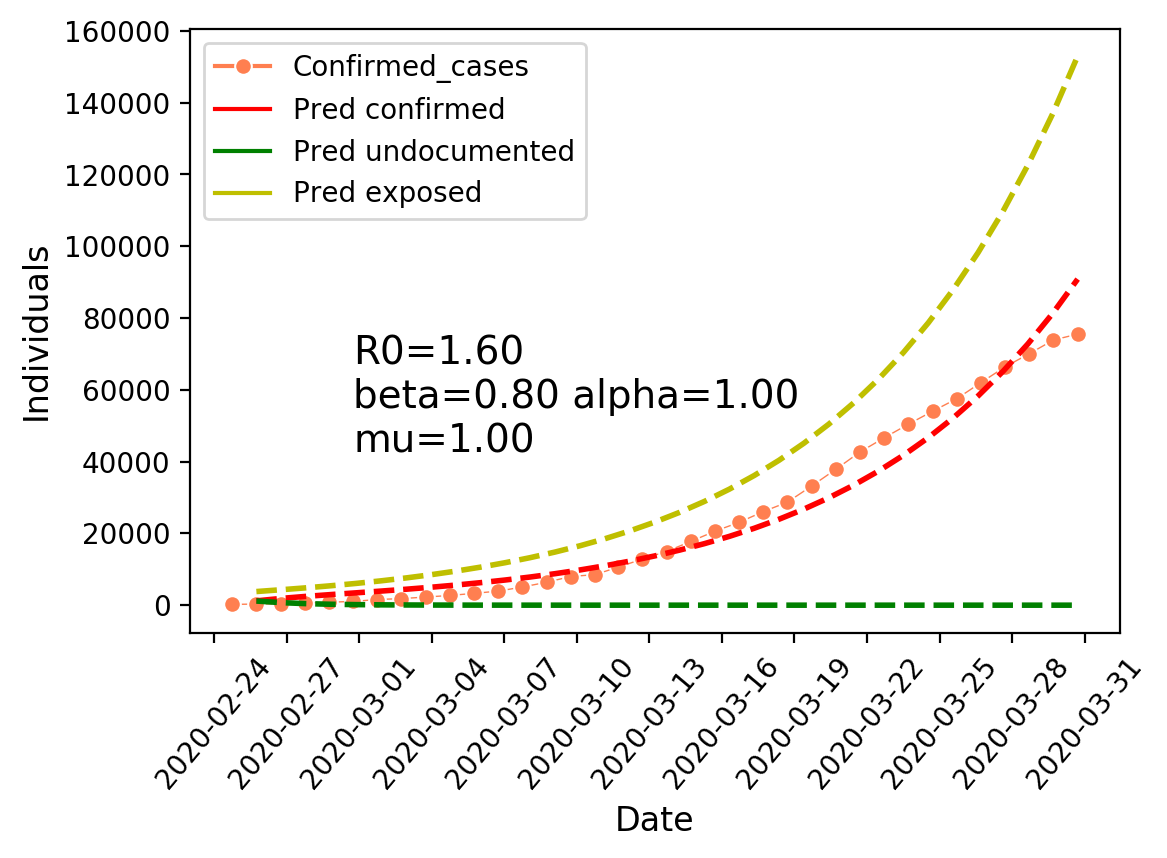

In [18]:
inf_col='Confirmed_cases'

f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col,color='coral')

def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

def a_generate(ndim, Npoints, *, seed=721, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z)

class mapper_multivariate_normal:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        # we have to use the cholesky decomposition to generate the samples
        self.L = np.linalg.cholesky(cov)
        
    def __call__(self, quantiles):
        values_standard = st.norm.isf(quantiles)
        values =  self.L @ values_standard.reshape(len(self.L), -1)
        values = values + self.mean.reshape(len(self.L), -1)
        return values.T
    
mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(3, 500, mapper=mapper)
#x_base = np.linspace(0, 10, 51)

#for params in p_seq:
 #   if sum(params)<np.inf and all(p>0 for p in params):
  #      #print(params)
   #     y_hat = solve_ivp(SEIR_ode,[0,days],x0,args=(params),t_eval=tempo)
    #    sns.lineplot(x=res.Day,y=y_hat.y[3],ax=ax,
     #                #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
      #               color='teal',alpha=0.2)
    
sns.lineplot(x='Day',y='Infected_documented',data=res,ax=ax,label='Pred confirmed',
             color='r')
sns.lineplot(x='Day',y='Infected_undocumented',data=res,ax=ax,
             label='Pred undocumented',color='g')
sns.lineplot(x='Day',y='Exposed',data=res,ax=ax,label='Pred exposed',color='y')

plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[-1],linewidth=2)
plt.setp(ax.lines[-2],linewidth=2)
plt.setp(ax.lines[-3],linewidth=2)
ax.lines[-1].set_linestyle("--")
ax.lines[-2].set_linestyle("--")
ax.lines[-3].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Individuals',fontsize=12)
plt.annotate('R0={:1.2f}\nbeta={:1.2f} alpha={:1.2f}\nmu={:1.2f}'.format(R0,beta,alpha,mu),
             xy=(mdates.date2num(data.index[5]), data[inf_col][-10]),
             fontsize=14,color='black')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

### Fitting initial conditions

In [69]:
BO=((0.,0.8,0.,0.),(1.,1.5,np.inf,np.inf)) 
def SEII_ode(t,x,alpha,beta):
        S,E,Ir,Iu=x
        dS=-beta*S*Ir/N-mu*beta*S*Iu/N
        dE=beta*S*Ir/N+mu*beta*S*Iu/N-E/Z
        dIr=alpha*E/Z-Ir/D
        dIu=(1-alpha)*E/Z-Iu/D
        return [dS,dE,dIr,dIu]
    
def SEIIinteg(ti,alpha,beta,E_i,Iu_i):
    #I0,beta,mu=p
    #print(t)
    x0=[N-E_i-Ir_i-Iu_i,E_i,Ir_i,Iu_i]
    sol=solve_ivp(SEII_ode,[0,days],x0,args=(alpha,beta),
                  t_eval=np.arange(0,days+1,1))
    lung=len(sol.y[0])
    #print(sol.y[1].reshape(1,25).shape)
    #print(np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0).shape)
    #print(np.concatenate((sol.y[1].reshape(25,1),sol.y[2].reshape(25,1)),axis=1).shape)
    #print(sol.y[1][ti])
    #print(sol.y[1].shape)
    return sol.y[2]
    #return np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0)
    #return np.concatenate((sol.y[1].reshape(lung,1),sol.y[2].reshape(lung,1)),axis=1).flatten()
    #return np.array([sol.y[1][t],sol.y[2][t]])
    
popt, pcov = curve_fit(SEIIinteg, tempo, 
                       np.array(data.loc[start:,'Confirmed_cases'].values).flatten(),
                       p0=[alpha,beta,E_i,Iu_i],bounds=BO)
#I0=popt[0]
alpha=popt[0]
beta=popt[1]
#mu=popt[2]
#Z=popt[3]
#D=popt[4]
E_i=popt[2]
Iu_i=popt[3]
x0=[N-E_i-Ir_i-Iu_i,E_i,Ir_i,Iu_i]
print('Fitted initial conditions:',x0)
R0=beta*(alpha*D+mu*(1-alpha)*D)
print('\nFitted parameters:')
print('beta={} alpha={} mu={} \n-> R0={}'.format(beta,alpha,mu,R0))
print('days_to_infect:{}  days_to_removed:{}'.format(Z,D))

Fitted initial conditions: [60466528.91272928, 7118.688358478976, 311.0, 6041.398912242063]

Fitted parameters:
beta=0.6033831551443661 alpha=0.6188646120172007 mu=0.55 
-> R0=1.8396185765455526
days_to_infect:3.45  days_to_removed:3.68


In [70]:
#x0=[N-E_i-I_i-R_i,E_i,I_i,R_i]
integ=solve_ivp(SEII_ode,[0,days],x0,args=(alpha,beta),t_eval=tempo)
res=pd.DataFrame()
res['Susceptible']=integ.y[0]
res['Exposed']=integ.y[1]
res['Infected_documented']=integ.y[2]
res['Infected_undocumented']=integ.y[3]
res['Step']=tempo
res['Day']=t

[None, None]

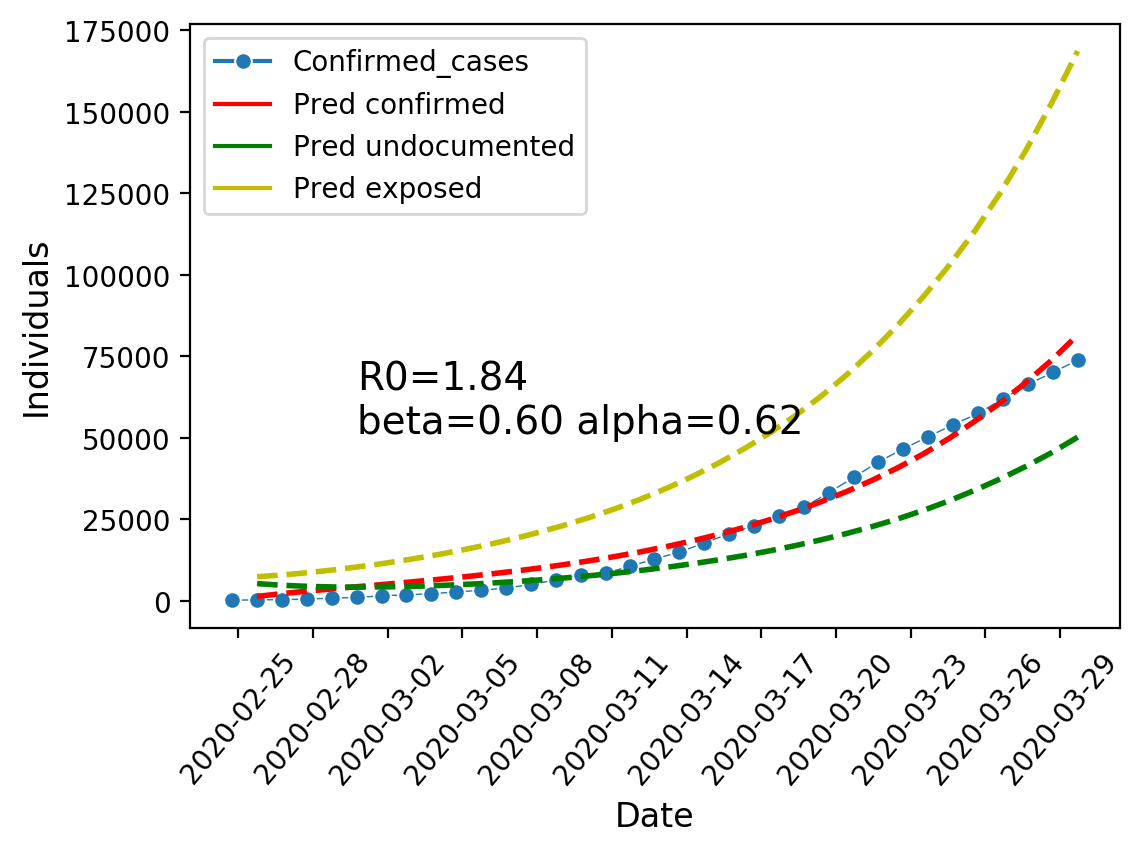

In [71]:
inf_col='Confirmed_cases'

f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col)

def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

def a_generate(ndim, Npoints, *, seed=721, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z)

class mapper_multivariate_normal:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        # we have to use the cholesky decomposition to generate the samples
        self.L = np.linalg.cholesky(cov)
        
    def __call__(self, quantiles):
        values_standard = st.norm.isf(quantiles)
        values =  self.L @ values_standard.reshape(len(self.L), -1)
        values = values + self.mean.reshape(len(self.L), -1)
        return values.T
    
mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(3, 500, mapper=mapper)
#x_base = np.linspace(0, 10, 51)

#for params in p_seq:
 #   if sum(params)<np.inf and all(p>0 for p in params):
  #      #print(params)
   #     y_hat = solve_ivp(SEIR_ode,[0,days],x0,args=(params),t_eval=tempo)
    #    sns.lineplot(x=res.Day,y=y_hat.y[3],ax=ax,
     #                #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
      #               color='teal',alpha=0.2)
    
sns.lineplot(x='Day',y='Infected_documented',data=res,ax=ax,label='Pred confirmed',
             color='r')
sns.lineplot(x='Day',y='Infected_undocumented',data=res,ax=ax,
             label='Pred undocumented',color='g')
sns.lineplot(x='Day',y='Exposed',data=res,ax=ax,label='Pred exposed',color='y')

plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[-1],linewidth=2)
plt.setp(ax.lines[-2],linewidth=2)
plt.setp(ax.lines[-3],linewidth=2)
ax.lines[-1].set_linestyle("--")
ax.lines[-2].set_linestyle("--")
ax.lines[-3].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Individuals',fontsize=12)
plt.annotate('R0={:1.2f}\nbeta={:1.2f} alpha={:1.2f}\n'.format(R0,beta,alpha,mu),
             xy=(mdates.date2num(data.index[5]), data[inf_col][-10]),
             fontsize=14,color='black')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

### Fitting everything

In [25]:
BO=((0.02,0.8,0.02,2.,2.,0.,0.),(1.,1.5,1.,5.,5.,np.inf,np.inf)) 
def SEII_ode(t,x,alpha,beta,mu,Z,D):
        S,E,Ir,Iu=x
        N=x.sum()
        dS=-beta*S*Ir/N-mu*beta*S*Iu/N
        dE=beta*S*Ir/N+mu*beta*S*Iu/N-E/Z
        dIr=alpha*E/Z-Ir/D
        dIu=(1-alpha)*E/Z-Iu/D
        return [dS,dE,dIr,dIu]
    
def SEIIinteg(ti,alpha,beta,mu,Z,D,E_i,Iu_i):
    #I0,beta,mu=p
    #print(t)
    x0=[N-E_i-Ir_i-Iu_i,E_i,Ir_i,Iu_i]
    sol=solve_ivp(SEII_ode,[0,days],x0,args=(alpha,beta,mu,Z,D),
                  t_eval=np.arange(0,days+1,1))
    lung=len(sol.y[0])
    #print(sol.y[1].reshape(1,25).shape)
    #print(np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0).shape)
    #print(np.concatenate((sol.y[1].reshape(25,1),sol.y[2].reshape(25,1)),axis=1).shape)
    #print(sol.y[1][ti])
    #print(sol.y[1].shape)
    return sol.y[2]
    #return np.concatenate((sol.y[1].reshape(1,25),sol.y[2].reshape(1,25)),axis=0)
    #return np.concatenate((sol.y[1].reshape(lung,1),sol.y[2].reshape(lung,1)),axis=1).flatten()
    #return np.array([sol.y[1][t],sol.y[2][t]])
    
popt, pcov = curve_fit(SEIIinteg, tempo, 
                       np.array(data.loc[start:,'Confirmed_cases'].values).flatten(),
                       p0=[alpha,beta,mu,Z,D,E_i,Iu_i],bounds=BO)
#I0=popt[0]
alpha=popt[0]
beta=popt[1]
mu=popt[2]
Z=popt[3]
D=popt[4]
E_i=popt[5]
Iu_i=popt[6]
R0=beta*(alpha*D+mu*(1-alpha)*D)
print('\nFitted parameters:')
print('beta={} alpha={} mu={} \n-> R0={}'.format(beta,alpha,mu,R0))
print('days_to_infect:{}  days_to_removed:{}'.format(Z,D))


Fitted parameters:
beta=0.8000570824700985 alpha=0.3417932794671174 mu=0.35050529613314363 
-> R0=1.9510620464258634
days_to_infect:4.136231541586099  days_to_removed:4.259670097252044


In [26]:
x0=[N-E_i-Ir_i-Iu_i,E_i,Ir_i,Iu_i]
integ=solve_ivp(SEII_ode,[0,days],x0,args=(alpha,beta,mu,Z,D),t_eval=tempo)
res=pd.DataFrame()
res['Susceptible']=integ.y[0]
res['Exposed']=integ.y[1]
res['Infected_documented']=integ.y[2]
res['Infected_undocumented']=integ.y[3]
res['Step']=tempo
res['Day']=t
print('\nInitial conditions:\n S={:.0f},E={:.0f},Ir={:.0f},Iu={:.0f}'.format(x0[0],x0[1],x0[2],x0[3]))


Initial conditions:
 S=60447793,E=1276,Ir=311,Iu=30620


[None, None]

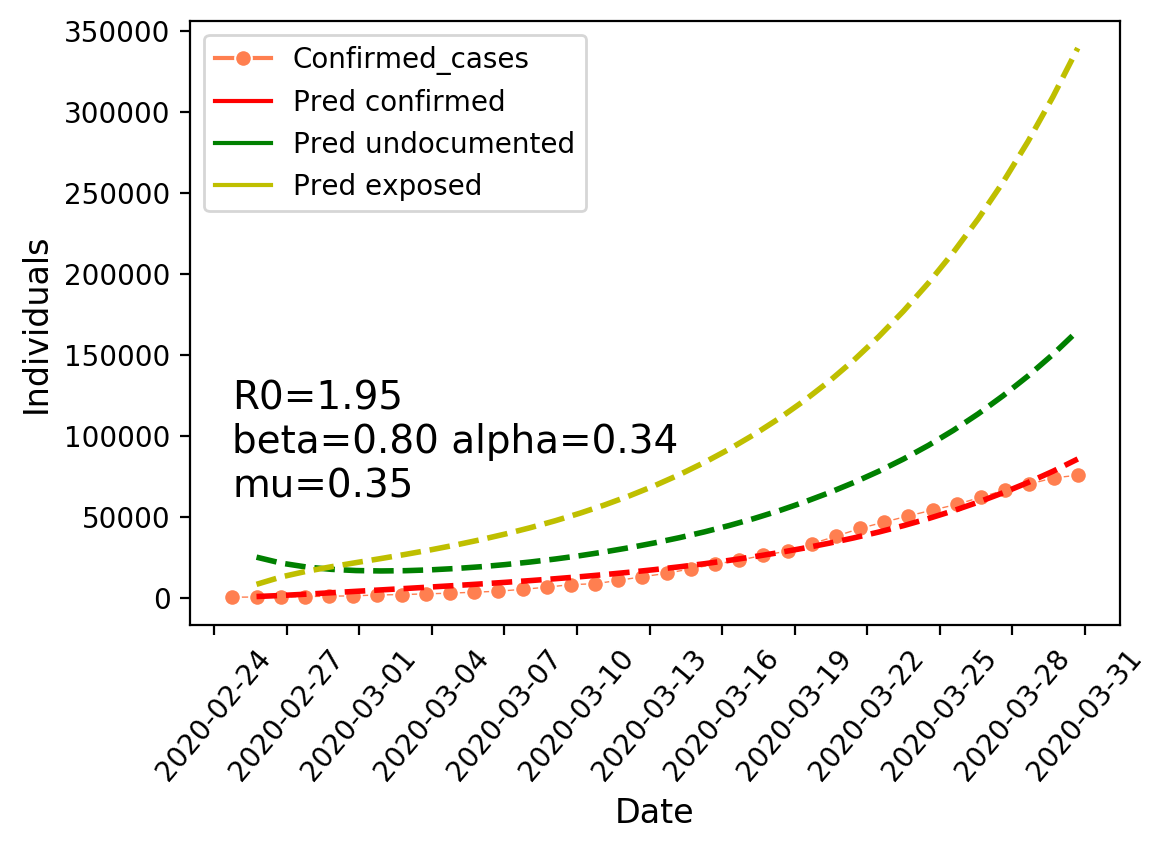

In [27]:
inf_col='Confirmed_cases'

f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col,color='coral')

def phi(d, precision=30): 
    x = 2.00
    for i in range(precision): 
        x = pow(1+x,1/(d+1)) 
    return x

def gaussian_icdf(q):
    return st.norm.isf(q)

def identity(x):
    return x

def a_generate(ndim, Npoints, *, seed=0.5, mapper=identity):
    # get the base for the dimension
    g = phi(ndim) 
    # this is the inizialization constant for the array
    alpha = ((1/g)**np.arange(1, ndim+1))%1  
    # reshaping to allow broadcasting
    alpha = alpha.reshape(1, -1) 
    # just the count of the sequence
    base = np.arange(Npoints).reshape(-1, 1) 
    # perform the actual calculation
    z = seed + alpha*base 
    # tale only the decimal part
    z = z % 1
    # return a mapped version to some distribution
    return mapper(z)

class mapper_multivariate_normal:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        # we have to use the cholesky decomposition to generate the samples
        self.L = np.linalg.cholesky(cov)
        
    def __call__(self, quantiles):
        values_standard = st.norm.isf(quantiles)
        values =  self.L @ values_standard.reshape(len(self.L), -1)
        values = values + self.mean.reshape(len(self.L), -1)
        return values.T
    
mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(len(popt), 1000, mapper=mapper)
#x_base = np.linspace(0, 10, 51)
rp=0
for params in p_seq:
    if sum(params)<np.inf and all(p>0 for p in params):
        rp+=1
        #print(params)
        x0_hat=[N-params[-2]-Ir_i-params[-1],params[-2],Ir_i,params[-1]]
        y_hat = solve_ivp(SEII_ode,[0,days],x0_hat,args=(params[:-2]),t_eval=tempo)
        sns.lineplot(x=res.Day,y=y_hat.y[2],ax=ax,
                     #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
                     color='teal',alpha=0.2)
    
sns.lineplot(x='Day',y='Infected_documented',data=res,ax=ax,label='Pred confirmed',
             color='r')
sns.lineplot(x='Day',y='Infected_undocumented',data=res,ax=ax,
             label='Pred undocumented',color='g')
sns.lineplot(x='Day',y='Exposed',data=res,ax=ax,label='Pred exposed',color='y')

plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[-1],linewidth=2)
plt.setp(ax.lines[-2],linewidth=2)
plt.setp(ax.lines[-3],linewidth=2)
ax.lines[-1].set_linestyle("--")
ax.lines[-2].set_linestyle("--")
ax.lines[-3].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Individuals',fontsize=12)
plt.annotate('R0={:1.2f}\nbeta={:1.2f} alpha={:1.2f}\nmu={:1.2f}'.format(R0,beta,alpha,mu),
             xy=(mdates.date2num(data.index[0]), data[inf_col][-5]),
             fontsize=14,color='black')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title

In [96]:
np.diag(np.sqrt(pcov))

/home/PERSONALE/francesco.durazzi2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([4.09932854e+00, 1.68542087e+02, 1.84131122e+02, 2.16909473e+01,
       3.92570046e+01, 1.85648198e+05, 1.66979833e+06])

### Long time behaviour

[None, None]

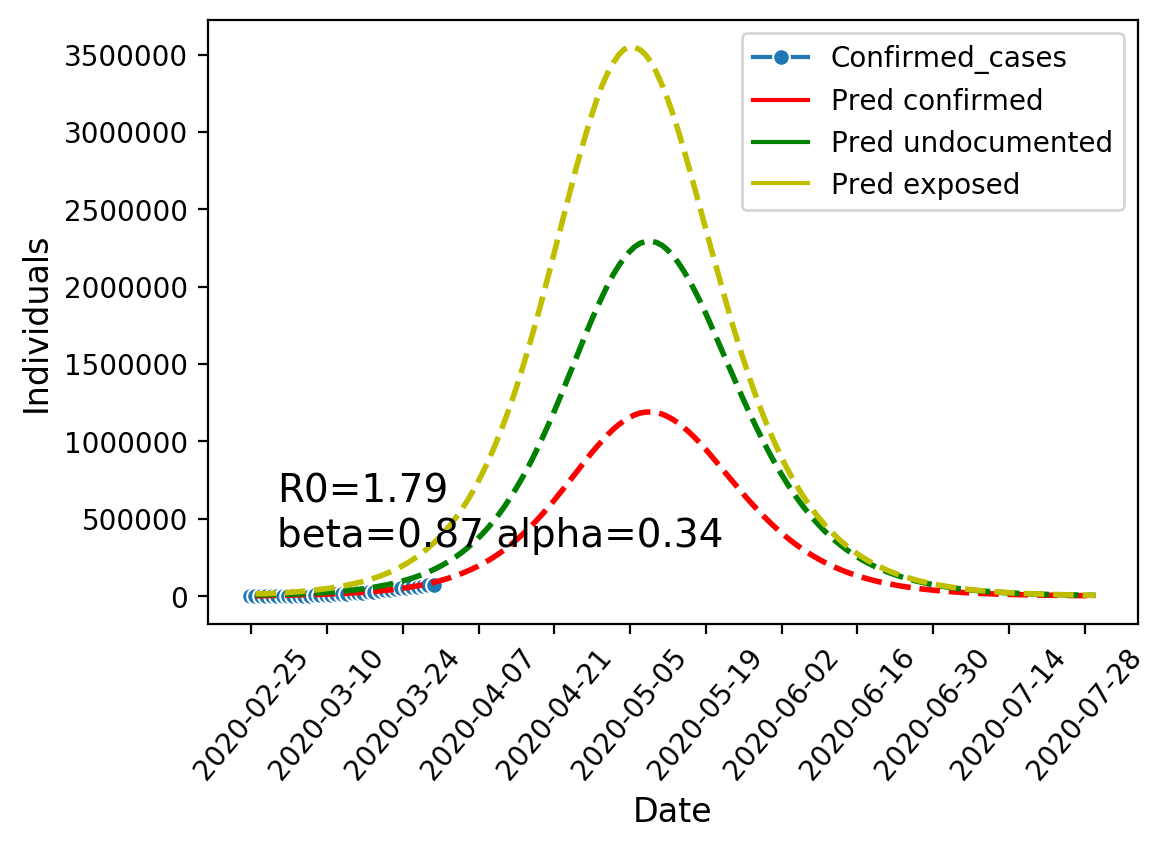

In [98]:
end = pd.Timestamp('2020-07-30')
days=(end-start).days+1
t_long = np.linspace(start.value, end.value, days)
t_long = pd.to_datetime(t_long)
tempo_long=np.linspace(1,days,days)

integ=solve_ivp(SEII_ode,[0,days],x0,args=(alpha,beta,mu,Z,D),t_eval=tempo_long)
res_long=pd.DataFrame()
res_long['Susceptible']=integ.y[0]
res_long['Exposed']=integ.y[1]
res_long['Infected_documented']=integ.y[2]
res_long['Infected_undocumented']=integ.y[3]
res_long['Step']=tempo_long
res_long['Day']=t_long

f,ax=plt.subplots(1,1,dpi=200)
sns.lineplot(x=data.index,y=inf_col,data=data,marker='o',ax=ax,
             label=inf_col)

mapper = mapper_multivariate_normal(mean=popt, cov=pcov)
p_seq = a_generate(len(popt), 100, mapper=mapper)
#x_base = np.linspace(0, 10, 51)

#for params in p_seq:
 #   if sum(params)<np.inf:
  #      y_hat = solve_ivp(SIR_ode,[0,days],x0,args=(params),t_eval=tempo_long)
   #     sns.lineplot(x=res_long.Day,y=y_hat.y[1],ax=ax,
    #                 #label='beta={:1.2f} mu={:1.2f}'.format(params[0],params[1]),
     #                color='teal',alpha=0.2)
    
sns.lineplot(x='Day',y='Infected_documented',data=res_long,ax=ax,label='Pred confirmed',
             color='r')
sns.lineplot(x='Day',y='Infected_undocumented',data=res_long,ax=ax,
             label='Pred undocumented',color='g')
sns.lineplot(x='Day',y='Exposed',data=res_long,ax=ax,label='Pred exposed',color='y')

plt.setp(ax.lines,linewidth=0.5)
plt.setp(ax.lines[-1],linewidth=2)
plt.setp(ax.lines[-2],linewidth=2)
plt.setp(ax.lines[-3],linewidth=2)
ax.lines[-1].set_linestyle("--")
ax.lines[-2].set_linestyle("--")
ax.lines[-3].set_linestyle("--")
ax.set_xlabel('Date',fontsize=12)
ax.set_ylabel('Individuals',fontsize=12)
plt.annotate('R0={:1.2f}\nbeta={:1.2f} alpha={:1.2f}\n'.format(R0,beta,alpha,mu),
             xy=(mdates.date2num(data.index[5]), data[inf_col][-10]),
             fontsize=14,color='black')
#plt.yscale('log')
#ax.set_xlim(pd.to_datetime('2020-02-15'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=50,fontsize=10 )
plt.setp( ax.yaxis.get_majorticklabels(), fontsize=10 )
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title